# Panel testing

In [1]:
import sys, os
import importlib

import numpy as np
import param
import pandas as pd
import panel as pn
pn.extension() # can be extended by certain extensions: vega, katex etc.
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

### Random point picking with distance

In [2]:
def pick_points(grid, n, distance, seed=None):
    '''
    grid: Set of possible pilot points, can be the grid
    n: desired number of pilot points, not guaranteed to be reached
    distance: distance or range, pilot points should be away from dat points'''

    np.random.seed(seed=seed)
    
    gl = grid.shape[0]
    gw = grid.shape[1]
    pilots = np.zeros((n, gw))

    # randomly pick initial point
    ipos = np.random.randint(0, gl)
    pilots[0, :2] = grid[ipos, :2]
    
    i = 1  # counter
    while i < n:

        # calculate all distances between remaining candidates and sim points
        dist = cdist(pilots[:i, :2], grid[:, :2])
        # choose candidates which are out of range
        mm = np.min(dist, axis=0)
        candidates = grid[mm > distance]
        # count candidates
        cl = candidates.shape[0]
        if cl < 1: break
        # randomly pick candidate and set next pilot point
        pos = np.random.randint(0, cl)
        pilots[i, :2] = candidates[pos, :2]

        i += 1

    # just return valid points if early break occured
    pilots = pilots[:i]

    return pilots

### Create topography data set

In [3]:
def create_topography (resolution, step=1, n=5, distance=3):

    from scipy.interpolate import griddata
    
    grid_x, grid_y = np.meshgrid(np.arange(0,resolution[0]+step,step), np.arange(0,resolution[1]+step,step))
    
    # combine position grids for random picking and interpolation
    grid = np.stack((grid_x.ravel(),grid_y.ravel())).T
    
    # picking positions
    points = pick_points(grid, n=n, distance=distance)
    # adding corners
    corners = np.array([[grid_x.min(), grid_y.min()], [grid_x.min(), grid_y.max()], [grid_x.max(), grid_y.min()], [grid_x.max(), grid_y.max()]])
    points = np.vstack([points, corners])
    # picking values
    values = np.random.randint(0, resolution[2], size=n+4)

    # interpolation
    z = griddata(points, values, grid, method='cubic', fill_value=0)
    
    # regridding the value grid
    grid_z = np.nan * np.empty((resolution[1],resolution[0]))
    grid_z[grid[:,1]-1, grid[:,0]-1] = z
    
    return grid_x, grid_y, grid_z, points

In [4]:
resolution = [200, 150, 200]
step = 1
points_n = 4
distance = 5

x, y, z, p = create_topography(resolution, step, n=points_n, distance=distance)

### Visualization

In [5]:
pp_width = 1280
pp_height = 800
pp_dpi = 100

map_width = 800
map_height = 600

In [6]:
# how to get dpi of projector for matplotlib


In [7]:
def plot (grid_x, grid_y, grid_z, points=None, cmap='gist_earth', width=800, height=600, dpi=62):
    
    #z_min, z_max = -np.abs(grid_z).max(), np.abs(grid_z).max()
    ratio = grid_x.max() / grid_y.max()
    
    fig = plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)#, frameon=False)
    ax = fig.add_axes([0., 0., 1., 1.])
      
    c = ax.pcolormesh(grid_x, grid_y, grid_z, cmap='gist_earth')
    co = ax.contour(grid_x[:-1,:-1], grid_y[:-1,:-1], grid_z, colors='k')
    
    if points is not None:
        ax.scatter(points[:,0], points[:,1], color='k', marker='x')
    
    # 1) make patch invisible / like 'frameon=False', buggy
    #fig.patch.set_visible(False)
    # 2) Set whitespace to 0
    #fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

    
    # 3) Turn off axes and set axes limits
    #ax.axis('off')
    ax.set_axis_off()
    ax.axis([grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])
    

    
    #fig.colorbar(c, ax=ax)

    #plt.savefig('test.png', bbox_inches='tight', 
    #           transparent=True,
    #           pad_inches=0)
    
    return fig

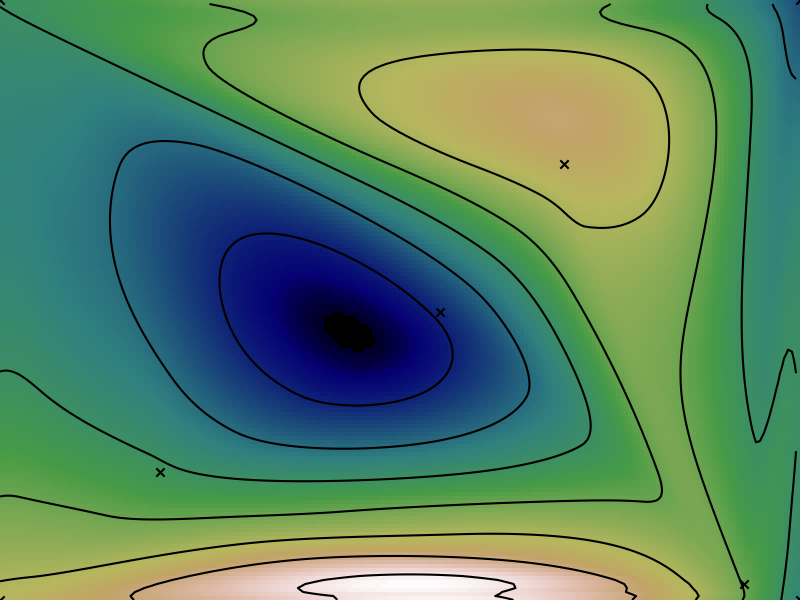

In [8]:
figure = plot(x, y, z, points=p, width=map_width, height=map_height, dpi=100)

## Test basic deployed panel

In [9]:
# adjust global panel css
# the standard deployed bokeh server uses a margin of 8px, remove that margin
css = '''
body {
  margin:0px;
  background-color: #ffffff;
}
.bk.plt_pane {
}
.panel {
  background-color: coral;
}
'''
pn.extension(raw_css=[css])

In [10]:
# Create a panel object and serve it within an external bokeh browser that will be opened in a seperate window
# in this special case, a "tight" layout would actually add again white space to the plt canvas, which was already cropped by specifying limits to the axis
mpl_pane = pn.pane.Matplotlib(figure, width=map_width, height=map_height, margin=[0,0,0,0], tight=False, dpi=pp_dpi, css_classes=['plt_pane'])

In [11]:
frequency  = pn.widgets.FloatSlider(name='Parameter A', value=2.5, start=0, end=5)
amplitude  = pn.widgets.FloatSlider(name='Parameter B', value=5, start=0, end=10)
legend     = pn.Column("<br>\n# Legend", frequency, amplitude)

In [12]:
# Combine panel and deploy bokeh server
bg_panel = pn.Row(mpl_pane, legend, width=pp_width, height=pp_height, sizing_mode='fixed', css_classes=['panel'])
# TODO: Add specific port? port=4242
bg_panel.show(threaded=False);

## Widgets

In [22]:
margin_left = pn.widgets.IntSlider(name='Left margin', value=0, start=0, end=150)

def callback_ml(target, event):
    m = target.margin
    n = event.new
    # just changing single indices does not trigger updating of pane
    target.margin = [m[0],m[1],m[2],n]

margin_left.link(mpl_pane, callbacks={'value': callback_ml})

Watcher(inst=IntSlider(end=150, name='Left margin'), cls=<class 'panel.widgets.slider.IntSlider'>, fn=<function Reactive.link.<locals>.link at 0x7fe6d40bee18>, mode='args', onlychanged=True, parameter_names=('value',), what='value')

In [23]:
margin_top = pn.widgets.IntSlider(name='Top margin', value=0, start=0, end=150)

def callback_mt(target, event):
    m = target.margin
    n = event.new
    # just changing single indices does not trigger updating of pane
    target.margin = [n,m[1],m[2],m[3]]

margin_top.link(mpl_pane, callbacks={'value': callback_mt})

Watcher(inst=IntSlider(end=150, name='Top margin'), cls=<class 'panel.widgets.slider.IntSlider'>, fn=<function Reactive.link.<locals>.link at 0x7fe6d40bebf8>, mode='args', onlychanged=True, parameter_names=('value',), what='value')

In [24]:
width = pn.widgets.IntSlider(name='Map width', value=map_width, start=map_width-100, end=map_width+100)

def callback_width(target, event):
    target.width = event.new
    target.param.trigger('object')

width.link(mpl_pane, callbacks={'value': callback_width})

Watcher(inst=IntSlider(end=900, name='Map width', start=700, value=800), cls=<class 'panel.widgets.slider.IntSlider'>, fn=<function Reactive.link.<locals>.link at 0x7fe6d40bb400>, mode='args', onlychanged=True, parameter_names=('value',), what='value')

In [25]:
height = pn.widgets.IntSlider(name='Map height', value=map_height, start=map_height-100, end=map_height+100)

def callback_height(target, event):
    target.height = event.new
    target.param.trigger('object')

height.link(mpl_pane, callbacks={'value': callback_height})

Watcher(inst=IntSlider(end=700, name='Map height', start=500, value=600), cls=<class 'panel.widgets.slider.IntSlider'>, fn=<function Reactive.link.<locals>.link at 0x7fe6d42e7048>, mode='args', onlychanged=True, parameter_names=('value',), what='value')

In [26]:
widgets = pn.Column("### Map positioning", margin_top, margin_left, width, height)
widgets

Column
    [0] Markdown(str)
    [1] IntSlider(end=150, name='Top margin')
    [2] IntSlider(end=150, name='Left margin')
    [3] IntSlider(end=900, name='Map width', start=700, value=800)
    [4] IntSlider(end=700, name='Map height', start=500, value=600)

In [27]:
print(mpl_pane)

Matplotlib(Figure, css_classes=['plt_pane'], dpi=100, height=700, margin=[50, 0, 0, 50], sizing_mode='fixed', width=900)


In [28]:
mpl_pane.margin

[50, 0, 0, 50]

## Matplotlib update

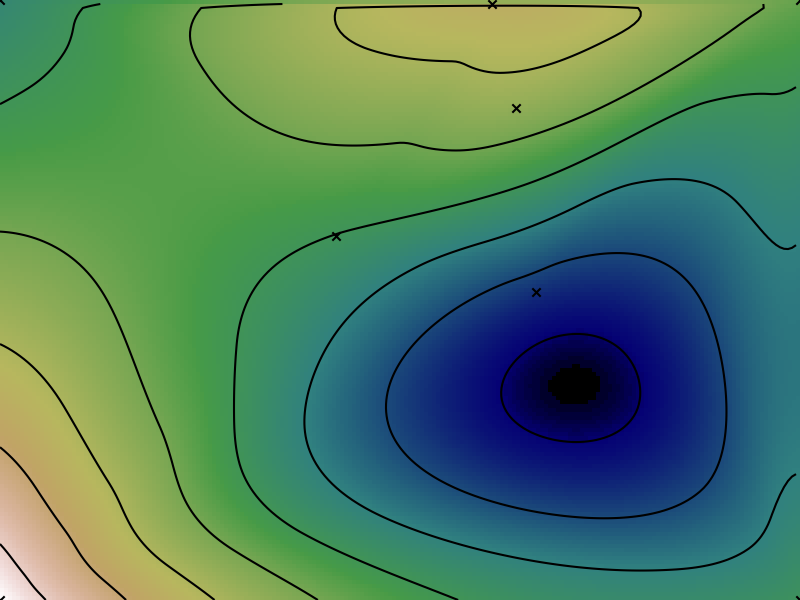

In [20]:
# update figure
x, y, z, p = create_topography(resolution, step, n=points_n, distance=distance)
mpl_pane.object = plot(x, y, z, points=p, width=map_width, height=map_height, dpi=100)
#mpl_pane.param.trigger('object')

### Add widgets
For example:
 * Alpha Channel (0-100)
 * Exageration (by exponent)
 * Point values (by seed)

Implementation within a plot and a projector class

In [58]:
pn.pane.Matplotlib?

Init signature: pn.pane.Matplotlib(object=None, **params)
Docstring:     
params(dpi=Integer, tight=Boolean, embed=Boolean, style=Dict, default_layout=ClassSelector, object=Parameter, align=ObjectSelector, aspect_ratio=Parameter, background=Parameter, css_classes=List, height=Integer, height_policy=ObjectSelector, margin=Parameter, max_height=Integer, max_width=Integer, min_height=Integer, min_width=Integer, sizing_mode=ObjectSelector, width=Integer, width_policy=ObjectSelector, name=String)

    A Matplotlib pane renders a matplotlib figure to png and wraps the
    base64 encoded data in a bokeh Div model. The size of the image in
    pixels is determined by scaling the size of the figure in inches
    by a dpi of 72, increasing the dpi therefore controls the
    resolution of the image not the displayed size.
    
Parameters of 'Matplotlib'

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan.
C/V= Constant/Variable, RO/RW = ReadOnly/R

In [57]:
fig = plt.figure(figsize=(3,3), facecolor='yellow', dpi=100)
fig.savefig('foo.png', facecolor='yellow')

<Figure size 300x300 with 0 Axes>